<a href="https://colab.research.google.com/github/shivarkrish18/college-projects/blob/main/FaceMaskDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 377 kB 4.9 MB/s 
     |████████████████████████████████| 20.6 MB 1.3 MB/s 
     |████████████████████████████████| 28.2 MB 1.4 MB/s 
     |████████████████████████████████| 12.4 MB 39.8 MB/s 
     |████████████████████████████████| 26.0 MB 1.5 MB/s 
     |████████████████████████████████| 50 kB 5.3 MB/s 
     |████████████████████████████████| 588.3 MB 18 kB/s 
     |████████████████████████████████| 578.1 MB 7.8 kB/s 
     |████████████████████████████████| 5.9 MB 45.2 MB/s 
     |████████████████████████████████| 578.1 MB 6.2 kB/s 
     |████████████████████████████████| 511.8 MB 27 kB/s 
     |████████████████████████████████| 511.7 MB 28 kB/s 
     |████████████████████████████████| 511.7 MB 212 bytes/s 
     |████████████████████████████████| 498.0 MB 14 kB/s 
     |████████████████████████████████| 498.4 MB 26 kB/s 
     |█████████████████████

[INFO] loading images...


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


9406464/9406464 [==============================] - 0s 0us/step
[INFO] compiling model...
[INFO] training head...


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
95/95 [==============================] - 44s 360ms/step - loss: 0.3691 - accuracy: 0.8609 - val_loss: 0.1710 - val_accuracy: 0.9557
Epoch 2/20
95/95 [==============================] - 32s 340ms/step - loss: 0.1325 - accuracy: 0.9697 - val_loss: 0.1017 - val_accuracy: 0.9726
Epoch 3/20
95/95 [==============================] - 32s 338ms/step - loss: 0.0954 - accuracy: 0.9750 - val_loss: 0.0787 - val_accuracy: 0.9765
Epoch 4/20
95/95 [==============================] - 32s 339ms/step - loss: 0.0779 - accuracy: 0.9782 - val_loss: 0.0691 - val_accuracy: 0.9804
Epoch 5/20
95/95 [==============================] - 41s 428ms/step - loss: 0.0680 - accuracy: 0.9822 - val_loss: 0.0590 - val_accuracy: 0.9831
Epoch 6/20
95/95 [==============================] - 32s 334ms/step - loss: 0.0558 - accuracy: 0.9825 - val_loss: 0.0592 - val_accuracy: 0.9817
Epoch 7/20
95/95 [==============================] - 33s 350ms/step - loss: 0.0591 - accuracy: 0.9796 - val_loss: 0.0520 - val_accuracy: 0.9844

NameError: ignored

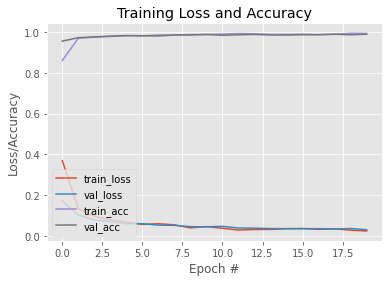

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

DIRECTORY = r"/content/drive/MyDrive/dataset"
CATEGORIES = ["with_mask", "without_mask"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

[INFO] loading face detector model...
[INFO] loading face mask detector model...
[INFO] computing face detections...
1/1 [==============================] - 1s 1s/step
Output


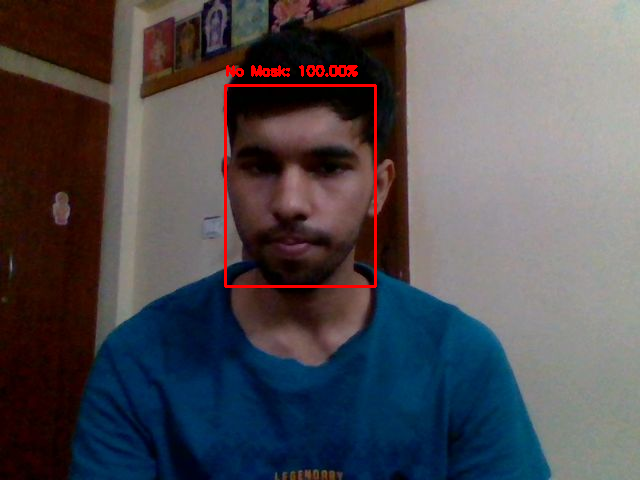

[INFO] computing face detections...
1/1 [==============================] - 0s 31ms/step
Output


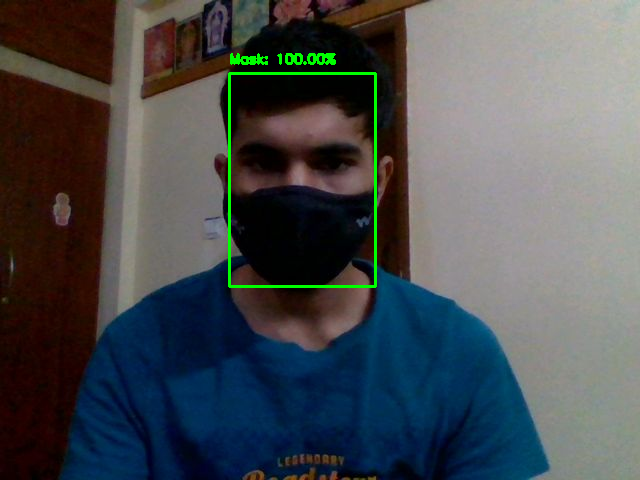

In [20]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow
import numpy as np
import cv2
import os
def mask_image():
	# construct the argument parser and parse the arguments
    array = ["photo.jpg","photo1.jpg"]

    # load our serialized face detector model from disk
    print("[INFO] loading face detector model...")
    prototxtPath = "deploy.prototxt"
    weightsPath = "res10_300x300_ssd_iter_140000.caffemodel"
    net = cv2.dnn.readNet(prototxtPath, weightsPath)

    # load the face mask detector model from disk
    print("[INFO] loading face mask detector model...")
    model = load_model("mask_detector.model")
    
    for img in array:
      image = cv2.imread(img)
      orig = image.copy()
      (h, w) = image.shape[:2]

      # construct a blob from the image
      blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
        (104.0, 177.0, 123.0))

      # pass the blob through the network and obtain the face detections
      print("[INFO] computing face detections...")
      net.setInput(blob)
      detections = net.forward()

      # loop over the detections
      for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with
        # the detection
        confidence = detections[0, 0, i, 2]

        # filter out weak detections by ensuring the confidence is
        # greater than the minimum confidence
        if confidence > 0.5:
          # compute the (x, y)-coordinates of the bounding box for
          # the object
          box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
          (startX, startY, endX, endY) = box.astype("int")

          # ensure the bounding boxes fall within the dimensions of
          # the frame
          (startX, startY) = (max(0, startX), max(0, startY))
          (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

          # extract the face ROI, convert it from BGR to RGB channel
          # ordering, resize it to 224x224, and preprocess it
          face = image[startY:endY, startX:endX]
          face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
          face = cv2.resize(face, (224, 224))
          face = img_to_array(face)
          face = preprocess_input(face)
          face = np.expand_dims(face, axis=0)

          # pass the face through the model to determine if the face
          # has a mask or not
          (mask, withoutMask) = model.predict(face)[0]

          # determine the class label and color we'll use to draw
          # the bounding box and text
          label = "Mask" if mask > withoutMask else "No Mask"
          color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

          # include the probability in the label
          label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

          # display the label and bounding box rectangle on the output
          # frame
          cv2.putText(image, label, (startX, startY - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
          cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

      # show the output image
      print("Output" )
      cv2_imshow(image)
      cv2.waitKey(0)
	
if __name__ == "__main__":
	mask_image()